In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sys
import os

sys.path.append('../src')
from target_engineering import RFMClustering

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# Cell 2: Load Data from Task 3
# -------------------------------------------------------------
data_path = "../data/processed/model_ready_features.csv"
df = pd.read_csv(data_path)

print(f"📊 Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst few rows:")
display(df.head())

📊 Data loaded: 95662 rows, 15 columns

First few rows:


,transaction_count,amount_median,amount_std,value_median,recency_days,frequency_per_month,Amount_log,Value_log,Amount_capped,transaction_hour,transaction_dayofweek,is_weekend,ProductCategory,ChannelId,CountryCode
0,119,500.0,3042.29,1000.0,1,40.112360,8.580544,6.908755,1000.0,2,3,0,airtime,ChannelId_3,256
1,119,500.0,3042.29,1000.0,1,40.112360,8.367997,3.044522,-20.0,2,3,0,financial_services,ChannelId_2,256
2,2,500.0,0.00,500.0,82,6.666667,8.481980,6.216606,500.0,2,3,0,airtime,ChannelId_3,256
3,38,1000.0,17169.24,2000.0,6,13.411765,9.341544,8.864464,7075.0,3,3,0,utility_bill,ChannelId_3,256
4,38,1000.0,17169.24,2000.0,6,13.411765,8.211483,6.469250,-644.0,3,3,0,financial_services,ChannelId_2,256


In [4]:
# Cell 3: Check Available RFM Features
# -------------------------------------------------------------
print("Available columns for RFM analysis:")
rfm_candidates = ['recency', 'frequency', 'monetary', 'transaction_count', 
                  'amount_median', 'value_median', 'recency_days', 
                  'frequency_per_month']

available_rfm = [col for col in rfm_candidates if col in df.columns]
print(f"✅ Available RFM features: {available_rfm}")

Available columns for RFM analysis:
✅ Available RFM features: ['transaction_count', 'amount_median', 'value_median', 'recency_days', 'frequency_per_month']


In [7]:
# Cell 4: Simplified RFM Clustering (Your data is already aggregated!)
# -------------------------------------------------------------
print("="*60)
print("SIMPLIFIED RFM CLUSTERING")
print("="*60)

print("my data appears to already be at customer level!")
print("Each row likely represents one customer's aggregated behavior.")

# 1. Create CustomerId if missing
if 'CustomerId' not in df.columns:
    df['CustomerId'] = [f'CUST_{i:06d}' for i in range(len(df))]
    print(f"✅ Created synthetic Customer IDs")

# 2. Select RFM features - use what you have
rfm_features = {
    'recency': 'recency_days',  # Days since last transaction
    'frequency': 'frequency_per_month',  # Transactions per month
    'monetary': 'value_median'  # Median transaction value
}

# Check which features we actually have
available_features = {}
for rfm_name, col_name in rfm_features.items():
    if col_name in df.columns:
        available_features[rfm_name] = col_name
        print(f"✅ Using '{col_name}' for {rfm_name}")
    else:
        print(f"⚠️ Missing '{col_name}' for {rfm_name}")

# 3. Create RFM dataframe
rfm_data = df[['CustomerId']].copy()
for rfm_name, col_name in available_features.items():
    rfm_data[rfm_name] = df[col_name]

print(f"\n📊 RFM Data Shape: {rfm_data.shape}")
print("Preview:")
display(rfm_data.head())


SIMPLIFIED RFM CLUSTERING
my data appears to already be at customer level!
Each row likely represents one customer's aggregated behavior.
✅ Using 'recency_days' for recency
✅ Using 'frequency_per_month' for frequency
✅ Using 'value_median' for monetary

📊 RFM Data Shape: (95662, 4)
Preview:


,CustomerId,recency,frequency,monetary
0,CUST_000000,1,40.112360,1000.0
1,CUST_000001,1,40.112360,1000.0
2,CUST_000002,82,6.666667,500.0
3,CUST_000003,6,13.411765,2000.0
4,CUST_000004,6,13.411765,2000.0


In [8]:
# Cell 5: Prepare for Clustering
# -------------------------------------------------------------
print("="*60)
print("PREPARING FOR CLUSTERING")
print("="*60)

# Handle missing values
for col in ['recency', 'frequency', 'monetary']:
    if col in rfm_data.columns:
        rfm_data[col] = rfm_data[col].fillna(rfm_data[col].median())

# Apply log transformation for skewed features (from EDA findings)
if 'monetary' in rfm_data.columns:
    rfm_data['monetary_log'] = np.log1p(rfm_data['monetary'])
if 'frequency' in rfm_data.columns:
    rfm_data['frequency_log'] = np.log1p(rfm_data['frequency'])

# Select final features for clustering
features_for_clustering = []
for col in ['recency', 'frequency_log', 'monetary_log']:
    if col in rfm_data.columns:
        features_for_clustering.append(col)

print(f"Features for clustering: {features_for_clustering}")

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_data[features_for_clustering])

print(f"Scaled data shape: {X_scaled.shape}")


PREPARING FOR CLUSTERING
Features for clustering: ['recency', 'frequency_log', 'monetary_log']
Scaled data shape: (95662, 3)


In [9]:
# Cell 6: Perform K-Means Clustering
# -------------------------------------------------------------
print("="*60)
print("PERFORMING K-MEANS CLUSTERING (k=3)")
print("="*60)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

rfm_data['cluster'] = cluster_labels
rfm_data['cluster'] = rfm_data['cluster'].astype(int)

print("✅ Clustering complete!")
print(f"Cluster distribution:")
print(rfm_data['cluster'].value_counts().sort_index())


PERFORMING K-MEANS CLUSTERING (k=3)
✅ Clustering complete!
Cluster distribution:
cluster
0    59262
1    23377
2    13023
Name: count, dtype: int64


In [10]:
# Cell 7: Analyze Clusters and Identify High-Risk
# -------------------------------------------------------------
print("="*60)
print("ANALYZING CLUSTERS")
print("="*60)

# Calculate cluster statistics
for feature in ['recency', 'frequency', 'monetary']:
    if feature in rfm_data.columns:
        print(f"\n📊 {feature.upper()} by cluster (median):")
        stats = rfm_data.groupby('cluster')[feature].median()
        for cluster, value in stats.items():
            print(f"  Cluster {cluster}: {value:.2f}")

# Identify high-risk cluster (high recency, low frequency, low monetary)
print("\n🔍 Identifying high-risk cluster...")

# Calculate risk score for each cluster
risk_scores = {}
for cluster in sorted(rfm_data['cluster'].unique()):
    cluster_data = rfm_data[rfm_data['cluster'] == cluster]
    
    # Normalize risk factors (higher = more risky)
    risk_factors = []
    
    if 'recency' in rfm_data.columns:
        # Higher recency = more risky (inactive longer)
        recency_norm = cluster_data['recency'].median() / rfm_data['recency'].max()
        risk_factors.append(recency_norm)
    
    if 'frequency' in rfm_data.columns:
        # Lower frequency = more risky
        freq_norm = 1 - (cluster_data['frequency'].median() / rfm_data['frequency'].max())
        risk_factors.append(freq_norm)
    
    if 'monetary' in rfm_data.columns:
        # Lower monetary = more risky
        monetary_norm = 1 - (cluster_data['monetary'].median() / rfm_data['monetary'].max())
        risk_factors.append(monetary_norm)
    
    risk_scores[cluster] = np.mean(risk_factors) if risk_factors else 0

# Cluster with highest risk score is high-risk
high_risk_cluster = max(risk_scores, key=risk_scores.get)

print("\n📈 Cluster Risk Scores:")
for cluster, score in risk_scores.items():
    risk_label = "🚨 HIGH-RISK" if cluster == high_risk_cluster else "✅ Low-Risk"
    print(f"  Cluster {cluster}: {score:.3f} - {risk_label}")


ANALYZING CLUSTERS

📊 RECENCY by cluster (median):
  Cluster 0: 3.00
  Cluster 1: 6.00
  Cluster 2: 54.00

📊 FREQUENCY by cluster (median):
  Cluster 0: 80.49
  Cluster 1: 30.00
  Cluster 2: 38.18

📊 MONETARY by cluster (median):
  Cluster 0: 1000.00
  Cluster 1: 6000.00
  Cluster 2: 1000.00

🔍 Identifying high-risk cluster...

📈 Cluster Risk Scores:
  Cluster 0: 0.672 - ✅ Low-Risk
  Cluster 1: 0.686 - ✅ Low-Risk
  Cluster 2: 0.862 - 🚨 HIGH-RISK


In [11]:
# Cell 8: Create Target Variable
# -------------------------------------------------------------
print("="*60)
print("CREATING TARGET VARIABLE: is_high_risk")
print("="*60)

rfm_data['is_high_risk'] = (rfm_data['cluster'] == high_risk_cluster).astype(int)

high_risk_count = rfm_data['is_high_risk'].sum()
high_risk_pct = (high_risk_count / len(rfm_data)) * 100

print(f"✅ Target variable created!")
print(f"   High-risk customers: {high_risk_count:,} ({high_risk_pct:.1f}%)")
print(f"   Low-risk customers: {len(rfm_data) - high_risk_count:,} ({100-high_risk_pct:.1f}%)")

print("\n🎯 Distribution:")
print(rfm_data['is_high_risk'].value_counts().sort_index())

CREATING TARGET VARIABLE: is_high_risk
✅ Target variable created!
   High-risk customers: 13,023 (13.6%)
   Low-risk customers: 82,639 (86.4%)

🎯 Distribution:
is_high_risk
0    82639
1    13023
Name: count, dtype: int64


VISUALIZING CLUSTERS


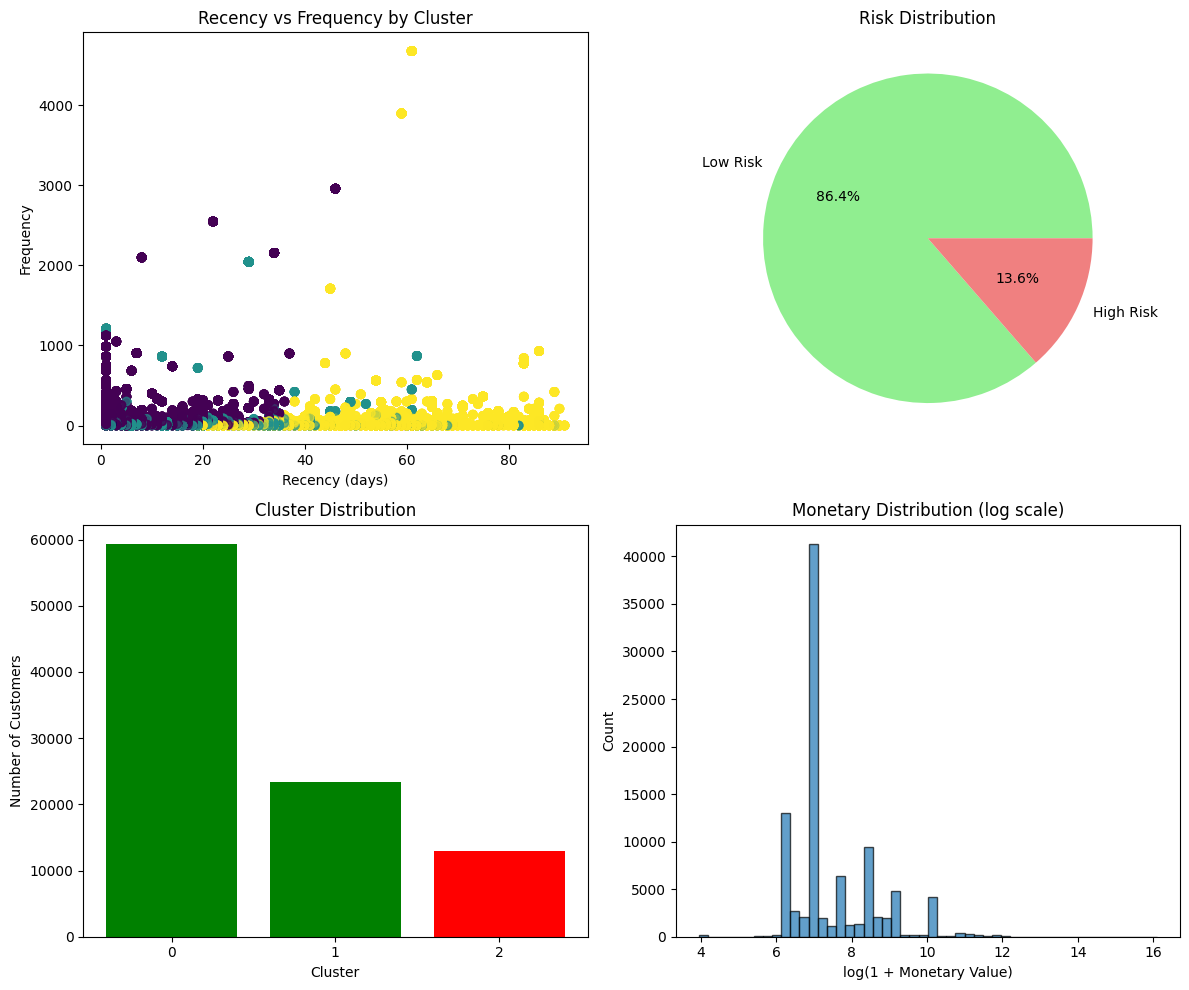

In [12]:
# Cell 9: Visualize the Clusters
# -------------------------------------------------------------
print("="*60)
print("VISUALIZING CLUSTERS")
print("="*60)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Recency vs Frequency
scatter = axes[0, 0].scatter(
    rfm_data['recency'],
    rfm_data['frequency'],
    c=rfm_data['cluster'],
    cmap='viridis',
    alpha=0.6
)
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Recency vs Frequency by Cluster')

# Plot 2: Risk distribution
risk_counts = rfm_data['is_high_risk'].value_counts()
axes[0, 1].pie(risk_counts.values, 
               labels=['Low Risk', 'High Risk'],
               colors=['lightgreen', 'lightcoral'],
               autopct='%1.1f%%')
axes[0, 1].set_title('Risk Distribution')

# Plot 3: Cluster sizes
cluster_counts = rfm_data['cluster'].value_counts().sort_index()
colors = ['red' if i == high_risk_cluster else 'green' for i in cluster_counts.index]
axes[1, 0].bar(cluster_counts.index.astype(str), cluster_counts.values, color=colors)
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_title('Cluster Distribution')

# Plot 4: Feature distributions
if 'monetary' in rfm_data.columns:
    axes[1, 1].hist(np.log1p(rfm_data['monetary']), bins=50, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('log(1 + Monetary Value)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Monetary Distribution (log scale)')

plt.tight_layout()
plt.show()


In [13]:
# Cell 10: Merge Target Back and Save
# -------------------------------------------------------------
print("="*60)
print("SAVING RESULTS")
print("="*60)

# Merge target back to original features
df_with_target = df.copy()
df_with_target['is_high_risk'] = rfm_data['is_high_risk'].values

# Save the data with target
output_path = "../data/processed/data_with_target.csv"
df_with_target.to_csv(output_path, index=False)

print(f"💾 Data with target saved to: {output_path}")
print(f"   Shape: {df_with_target.shape}")
print(f"   Columns: {list(df_with_target.columns)}")
print(f"   High-risk rows: {df_with_target['is_high_risk'].sum():,}")

print("\n✅ TASK 4 COMPLETE!")
print("Now I have 'is_high_risk' column for Task 5 model training.")




SAVING RESULTS
💾 Data with target saved to: ../data/processed/data_with_target.csv
   Shape: (95662, 17)
   Columns: ['transaction_count', 'amount_median', 'amount_std', 'value_median', 'recency_days', 'frequency_per_month', 'Amount_log', 'Value_log', 'Amount_capped', 'transaction_hour', 'transaction_dayofweek', 'is_weekend', 'ProductCategory', 'ChannelId', 'CountryCode', 'CustomerId', 'is_high_risk']
   High-risk rows: 13,023

✅ TASK 4 COMPLETE!
Now I have 'is_high_risk' column for Task 5 model training.
